# Cassava Leaf Disease Classification

As the second-largest provider of carbohydrates in Africa, `cassava` is a key food security crop grown by smallholder farmers because it can withstand harsh conditions. At least 80% of household farms in Sub-Saharan Africa grow this starchy root, but `viral diseases` are major sources of poor yields. With the help of data science, it may be possible to identify common diseases so they can be treated.

Existing methods of `disease detection` require farmers to solicit the help of government-funded agricultural experts to visually inspect and diagnose the plants. This suffers from being labor-intensive, low-supply and costly. As an `added challenge`, effective solutions for farmers must perform well under significant constraints, since African farmers may only have access to mobile-quality cameras with low-bandwidth.

This notebook is for the Kaggle's [Cassava Leaf Disease Classification](https://www.kaggle.com/c/cassava-leaf-disease-classification) competition where we have to identify the type of disease present on a Cassava Leaf image.

![](https://media.giphy.com/media/JYc3Q2iiHgayI/giphy.gif)

**More info about the competition**

In this competition, we introduce a dataset of `21,367 labeled images` collected during a regular survey in Uganda. Most images were `crowdsourced` from farmers taking `photos` of their gardens, and `annotated by experts` at the National Crops Resources Research Institute (NaCRRI) in collaboration with the AI lab at Makerere University, Kampala. This is in a format that most realistically represents what farmers would need to diagnose in real life.

Your task is to `classify each cassava image into four disease categories or a fifth category indicating a healthy leaf`. With your help, farmers may be able to quickly identify diseased plants, potentially saving their crops before they inflict irreparable damage.

**Getting packages**

In [1]:
import os
import re
import sys
import math
import json
import random
import itertools
from functools import partial

import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import albumentations as A 

import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, Sequential, mixed_precision
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import EfficientNetB3, InceptionV3
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau

from kaggle_datasets import KaggleDatasets


print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


## 🏂 Setting Up Things

**Configuring Hardware**, things configured here are `Mixed Precision`, `XLA` and `TPU`.

To know about [Mixed Precision](https://www.tensorflow.org/guide/mixed_precision) and [XLA](https://www.tensorflow.org/xla) follow the official `Tensorflow` docs via the `links`.

Here I've diabled `XLA` and `Mixed Precision` as I was facing issue (`InvalidArgumentError`) while loading the saved model and doing predictions (stage where I had issue).

```bash
InvalidArgumentError: No OpKernel was registered to support Op 'Conv2D' used by {{node sequential/inception_v3/conv2d/Conv2D}} with these attrs: [dilations=[1, 1, 1, 1], T=DT_BFLOAT16, strides=[1, 2, 2, 1], data_format="NHWC", use_cudnn_on_gpu=true, explicit_paddings=[], padding="VALID"]
Registered devices: [CPU]
Registered kernels:
  device='XLA_CPU_JIT'; T in [DT_FLOAT, DT_DOUBLE, DT_BFLOAT16, DT_HALF]
  device='CPU'; T in [DT_INT32]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]

	 [[sequential/inception_v3/conv2d/Conv2D]] [Op:__inference_predict_function_11991]
```

To view kernel which used this go to `version 5` of this kernel.

In [2]:
tf.keras.backend.clear_session()

XLA_ACCELERATE = False
MIXED_PRECISION = False

# Enabling XLA
if XLA_ACCELERATE:
    tf.config.optimizer.set_jit(True)
        
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
    # Enabling mixed precision for TPUs
    if MIXED_PRECISION:
        mixed_precision.set_global_policy('mixed_bfloat16')
        
except Exception as e:
    strategy = tf.distribute.get_strategy()

    # Enabling mixed precision for CPUs/GPUs
    if MIXED_PRECISION:
        mixed_precision.set_global_policy('mixed_float16')

        
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8


**Base Config**

In [3]:
class BaseConfig:
    SEED = 101
    
    TRAIN_CSV = '../input/cassava-leaf-disease-classification/train.csv'
    TRAIN_IMG_PATH = '../input/cassava-leaf-disease-classification/train_images/'
    TEST_IMG_PATH = '../input/cassava-leaf-disease-classification/test_images/'
    CLASS_MAP = '../input/cassava-leaf-disease-classification/label_num_to_disease_map.json'
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE

    IMAGE_SIZE = [512, 512]

    FOLDS = 3
    EPOCHS = 100
    CLASSES = ['0', '1', '2', '3', '4']
    
    GCS_PATH = KaggleDatasets().get_gcs_path('cassava-leaf-disease-classification')

    # Getting training and testing tfrecord filenames
    TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train_tfrecords/ld_train*.tfrec')
    TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test_tfrecords/ld_test*.tfrec')
    
    
    # ==========================
    # Setting up batch size
    # ==========================
    
    # When XLA is enabled, the batch size should be multiple of 
    # 128 (for TPU) or 64 (for CPU/GPU) as per Tensorflow docs
    if strategy.num_replicas_in_sync == 8:
        # BATCH_SIZE = 128 * strategy.num_replicas_in_sync
        
        # Due to running out of memory, using batch size as multiple of 8
        BATCH_SIZE = 8 * strategy.num_replicas_in_sync
    else:
        # BATCH_SIZE = 64 * strategy.num_replicas_in_sync
        
        # Due to running out of memory, using batch size as multiple of 8
        BATCH_SIZE = 8 * strategy.num_replicas_in_sync

**Understand the use of `tf.data.experimental.AUTOTUNE`**

The `tf.data` API provides a software pipelining mechanism through the `tf.data.Dataset.prefetch` transformation, which can be used to **decouple the time when data is produced from the time when data is consumed**. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either **manually tune** this value, or set it to `tf.data.experimental.AUTOTUNE` which will prompt the tf.data runtime to tune the value dynamically at runtime.

`tf.data.experimental.AUTOTUNE` defines appropriate number of processes that are free for working. This can be used to get the `number of processes` that can be used for `transorfmation`.

In [4]:
def seed_all(s):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(s)


# Seeding all
seed_all(BaseConfig.SEED)

In [5]:
# Dataset
df = pd.read_csv(BaseConfig.TRAIN_CSV)
df.label = df.label.astype('str')

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 21397


image_id label
4466   1797152583.jpg     2
3495   1615919700.jpg     1
4248   1759042176.jpg     2
13609  3435427625.jpg     2
6377   2143249620.jpg     3

In [6]:
# Label
name_of_diseases = pd.read_json(BaseConfig.CLASS_MAP, typ='series')
name_of_diseases

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

Looking at the `label` `count` in our `dataset`

<AxesSubplot:xlabel='label', ylabel='count'>

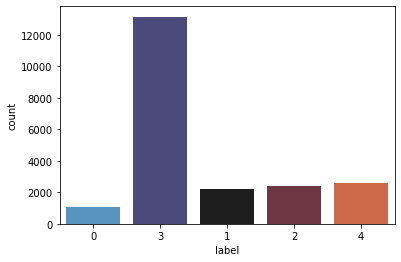

In [7]:
sns.countplot(x='label', data=df, palette='icefire')

**Plot images**

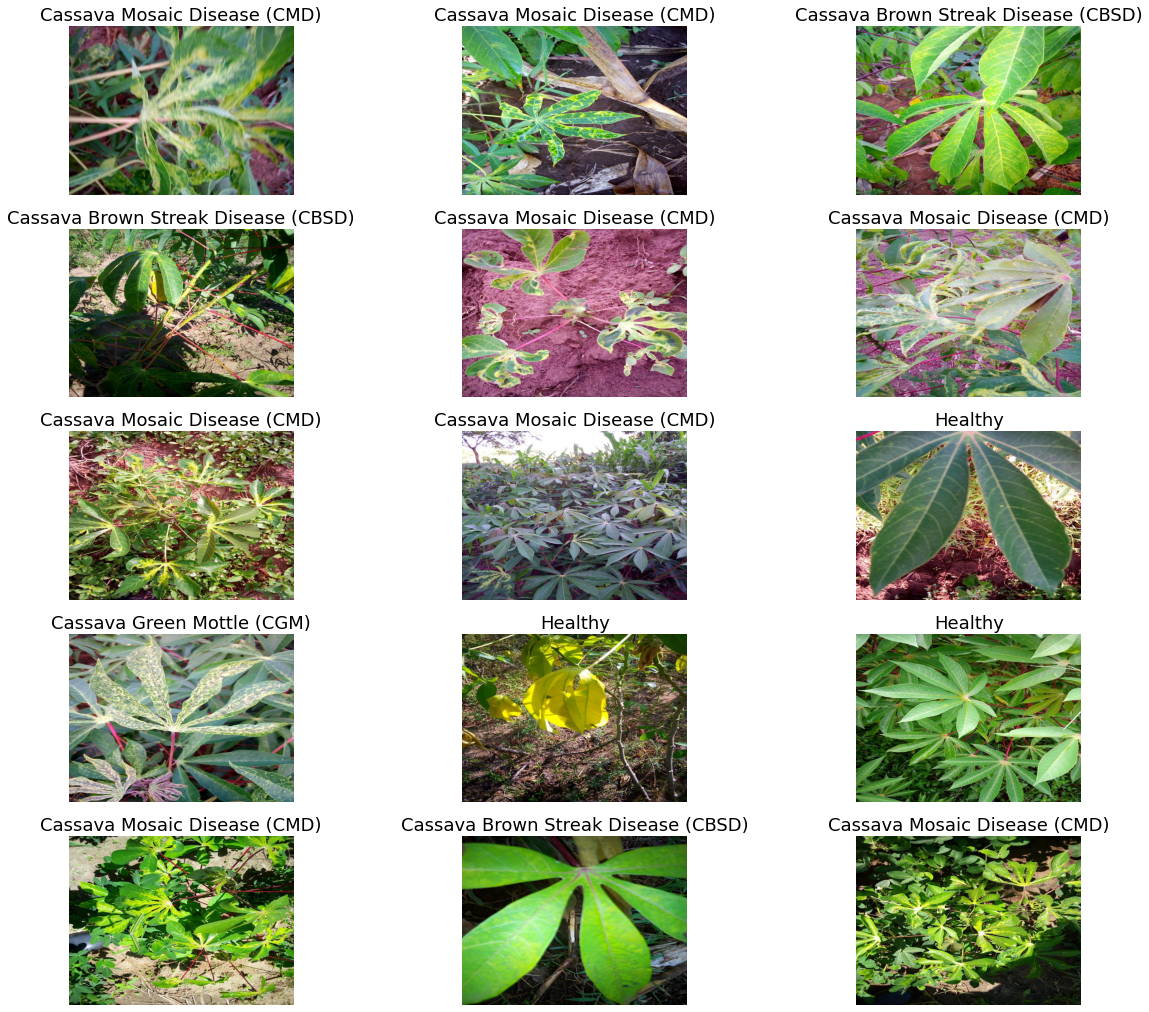

In [8]:
def plot_imgs(img_ids, labels):
    plt.figure(figsize=(20, 18))
    
    num_samples = len(labels)
    for idx, (img_id, label) in enumerate(zip(img_ids, labels)):
        num_cols = 3
        num_rows = (num_samples // num_cols) + (num_samples % num_cols)
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = cv2.imread(BaseConfig.TRAIN_IMG_PATH + '/' + img_id)
        
        # Reversing the color channle from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(name_of_diseases[int(label)], fontsize=18)
        plt.axis('off')
        
    plt.show()
    
    
tmp_df  = df.sample(15)
img_ids = tmp_df.image_id.values
labels  = tmp_df.label.values
plot_imgs(img_ids, labels)

## 🪂 Data Preparation

**Functions to work with tfrecords**

In [9]:
def decode_image(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [*BaseConfig.IMAGE_SIZE, 3])
    return img


def read_tfrecord(example, labeled):
    if labeled:
        tfrecord_format = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'target': tf.io.FixedLenFeature([], tf.int64)
        }
    else:
        tfrecord_format = {
            'image': tf.io.FixedLenFeature([], tf.string),
            'image_name': tf.io.FixedLenFeature([], tf.string)
        }
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    
    if labeled:
        label = tf.cast(example['target'], tf.float32)
        return image, label

    idnum = example['image_name']
    return image, idnum


def load_dataset(filenames, labeled=True, ordered=False):
    # Creating option for tf.data.Dataset
    ignore_order = tf.data.Options()
    
    if not ordered:
        # The outputs produced will not be in deterministic order
        # default is True
        ignore_order.experimental_deterministic = False
        
    # Creating dataset using multiple TFRecord files and with AUTOTUNE
    # it'll use all the processes for transformation
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=BaseConfig.AUTOTUNE)
    
    # Using data as soon as it streams in, rather than in its original order
    # if the ordered=False
    dataset = dataset.with_options(ignore_order)
    
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled),
        num_parallel_calls=BaseConfig.AUTOTUNE
    )

    return dataset

In [10]:
def data_augment(img, label):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_crop(img, size=[*BaseConfig.IMAGE_SIZE, 3])
    return img, label

In [11]:
# Getting dataset


''' Not using the albumentation's augmentations because while using it,
    it's giving the error below
    
    UnavailableError: failed to connect to all addresses
    Additional GRPC error information from remote target /job:localhost/replica:0/task:0/device:CPU:0:
    :{"created":"@1618946008.948648282","description":"Failed to pick subchannel","file":"third_party/grpc/src/core/ext/filters/client_channel/client_channel.cc","file_line":4143,"referenced_errors":[{"created":"@1618946008.948644997","description":"failed to connect to all addresses","file":"third_party/grpc/src/core/ext/filters/client_channel/lb_policy/pick_first/pick_first.cc","file_line":398,"grpc_status":14}]}
'''

def get_training_dataset(dataset, augment=True):
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=BaseConfig.AUTOTUNE)
        
    # Repeating training dataset infinitely
    dataset = dataset.repeat()
    
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BaseConfig.BATCH_SIZE)
    
    if augment:
        dataset = dataset.map(transform, num_parallel_calls=BaseConfig.AUTOTUNE)
        # dataset = albu_transforms_train(dataset)
        pass
    
    # Prefetch next batch while training (autotune prefetch buffer size)
    dataset = dataset.prefetch(BaseConfig.AUTOTUNE)
    return dataset


def get_validation_dataset(dataset, augment=True):
    dataset = dataset.batch(BaseConfig.BATCH_SIZE)

    if augment:
        #dataset = albu_transforms_valid(dataset)
        pass
    
    # Caching the elements in the dataset (this cache will persist until
    # the cache file is removed)
    dataset = dataset.cache()
    
    dataset = dataset.prefetch(BaseConfig.AUTOTUNE)
    return dataset


def get_test_dataset(ordered=False, augment=False):
    dataset = load_dataset(BaseConfig.TEST_FILENAMES, labeled=False, ordered=ordered)
    
    dataset = dataset.batch(BaseConfig.BATCH_SIZE)
    
    if augment:
        #dataset = albu_transforms_inference(dataset)
        pass
    
    dataset = dataset.prefetch(BaseConfig.AUTOTUNE)
    return dataset

In [12]:
def count_data_items(filenames):
    n = [
        int(re.compile(r'-([0-9]*)\.').search(filename).group(1))
        for filename in filenames
    ]
    
    return np.sum(n)

In [13]:
# training, validation slipt from the training dataset
TRAIN_VAL_SPLIT = 0.8

NUM_TRAINING_IMAGES   = int(count_data_items(BaseConfig.TRAINING_FILENAMES) * TRAIN_VAL_SPLIT)
NUM_VALIDATION_IMAGES = int(count_data_items(BaseConfig.TRAINING_FILENAMES) * (1 - TRAIN_VAL_SPLIT))
NUM_TEST_IMAGES       = count_data_items(BaseConfig.TEST_FILENAMES)

print(f'Training set size: {NUM_TRAINING_IMAGES}')
print(f'Validation set size: {NUM_VALIDATION_IMAGES}')
print(f'Testing set size: {NUM_TEST_IMAGES}')

Training set size: 17117
Validation set size: 4279
Testing set size: 1


## Data Augmentation

![](https://media.giphy.com/media/3ohzdQhmr2YrxHT45y/giphy.gif)

In [14]:
# Augmentation for training 
def albu_transforms_train(train_ds):
    transforms = A.Compose([
        A.RandomResizedCrop(BaseConfig.IMAGE_SIZE[0], BaseConfig.IMAGE_SIZE[1]),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomRotate90(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), shadow_dimension=5, p=0.5),
        A.CoarseDropout(p=0.5),            
        A.Resize(BaseConfig.IMAGE_SIZE[0], BaseConfig.IMAGE_SIZE[1]),
        A.ToFloat()
    ], p=1.)
    
    def aug_fn(image):
        data = {"image":image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    
    def set_shapes(img, label, img_shape=(*BaseConfig.IMAGE_SIZE,3)):
        img.set_shape(img_shape)
        return img, label
    
    ds_alb = train_ds.map(partial(process_data), num_parallel_calls=BaseConfig.AUTOTUNE).prefetch(BaseConfig.AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=BaseConfig.AUTOTUNE)
    ds_alb = ds_alb.repeat()
    ds_alb = ds_alb.batch(BaseConfig.BATCH_SIZE)
    print(len(list(ds_alb)))
    return ds_alb


# Augmentation for validation
def albu_transforms_valid(val_ds):
    transforms = A.Compose([
        A.ToFloat(),
        A.CenterCrop(BaseConfig.IMAGE_SIZE[0], BaseConfig.IMAGE_SIZE[1], p=1.),
        A.Resize(BaseConfig.IMAGE_SIZE[0], BaseConfig.IMAGE_SIZE[1])
    ], p=1.)
    
    def aug_fn(image):
        data = {"image":image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        print(aug_img.shape)
        return aug_img, label
    
    def set_shapes(img, label, img_shape=(*BaseConfig.IMAGE_SIZE, 3)):
        img.set_shape(img_shape)
        return img, label
    
    ds_alb = val_ds.map(partial(process_data), num_parallel_calls=BaseConfig.AUTOTUNE).prefetch(BaseConfig.AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=BaseConfig.AUTOTUNE).batch(BaseConfig.BATCH_SIZE)
    return ds_alb


# Augmentation for Inference
def albu_transforms_inference(test_ds):
    transforms = A.Compose([
        A.Transpose(p=0.5),
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.ToFloat(),
        A.RandomResizedCrop(BaseConfig.IMAGE_SIZE[0], BaseConfig.IMAGE_SIZE[1])
    ], p=1.)
    
    def aug_fn(image):
        data = {"image":image}
        aug_data = transforms(**data)
        aug_img = aug_data["image"]
        aug_img = tf.cast(aug_img, tf.float32)
        return aug_img

    def process_data(image, label):
        aug_img = tf.numpy_function(func=aug_fn, inp=[image], Tout=tf.float32)
        return aug_img, label
    
    def set_shapes(img, label, img_shape=(*BaseConfig.IMAGE_SIZE, 3)):
        img.set_shape(img_shape)
        return img, label
    
    ds_alb = test_ds.map(partial(process_data), num_parallel_calls=BaseConfig.AUTOTUNE).prefetch(BaseConfig.AUTOTUNE)
    ds_alb = ds_alb.map(set_shapes, num_parallel_calls=BaseConfig.AUTOTUNE).batch(BaseConfig.BATCH_SIZE)
    return ds_alb

**Applying sophisticated agumentation**

- CutMix
- MixUp
- FixM

For more info have a look at the following kernels, [link](https://www.kaggle.com/saife245/cutmix-vs-mixup-vs-gridmask-vs-cutout) and [link](https://www.kaggle.com/cdeotte/cutmix-and-mixup-on-gpu-tpu) and for more info about these transformation follow this blog via this [link](https://medium.com/@virajbagal12/mixed-sample-data-augmentation-721e65093fcf).

**CutMix Agumentation**

In [15]:
def CutMix(image, label, DIM, PROBABILITY = 1.0):
#     # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
#     # output - a batch of images with cutmix applied
#     CLASSES = len(BaseConfig.CLASSES)
#     BATCH_SIZE = BaseConfig.BATCH_SIZE
    
#     imgs = []; labs = []
#     for j in range(len(image)):
#         # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
#         P = tf.cast(tf.random.uniform([], 0, 1) <= PROBABILITY, tf.int32)
        
#         # CHOOSE RANDOM IMAGE TO CUTMIX WITH
#         k = tf.cast(tf.random.uniform([], 0, BATCH_SIZE), tf.int32)
        
#         # CHOOSE RANDOM LOCATION
#         x = tf.cast(tf.random.uniform([], 0, DIM), tf.int32)
#         y = tf.cast(tf.random.uniform([], 0, DIM), tf.int32)
        
#         # this is beta dist with alpha=1.0
#         b = tf.random.uniform([], 0, 1)
        
#         WIDTH = tf.cast(DIM * tf.math.sqrt(1-b), tf.int32) * P
#         ya = tf.math.maximum(0, y-WIDTH // 2)
#         yb = tf.math.minimum(DIM, y+WIDTH // 2)
#         xa = tf.math.maximum(0, x-WIDTH // 2)
#         xb = tf.math.minimum(DIM, x+WIDTH // 2)
        
#         # MAKE CUTMIX IMAGE
#         one = image[j, ya:yb, 0:xa, :]
#         two = image[k, ya:yb, xa:xb ,:]
#         three = image[j, ya:yb, xb:DIM, :]
#         middle = tf.concat([one, two, three], axis=1)
#         img = tf.concat([image[j, 0:ya, :, :], middle, image[j, yb:DIM, :, :]], axis=0)
#         imgs.append(img)
        
#         # MAKE CUTMIX LABEL
#         a = tf.cast(WIDTH*WIDTH/DIM/DIM, tf.float32)
#         labs.append((1-a)*label[j] + a*label[k])
            
#     # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
#     image2 = tf.reshape(tf.stack(imgs), (BATCH_SIZE, DIM, DIM, 3))
#     label2 = tf.reshape(tf.stack(labs), (BATCH_SIZE, CLASSES))


    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = BaseConfig.IMAGE_SIZE[0]
    CLASSES = len(BaseConfig.CLASSES)
    AUG_BATCH = BaseConfig.BATCH_SIZE
        
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,))
    
    return image2, label2

**View cutmix tranformations**

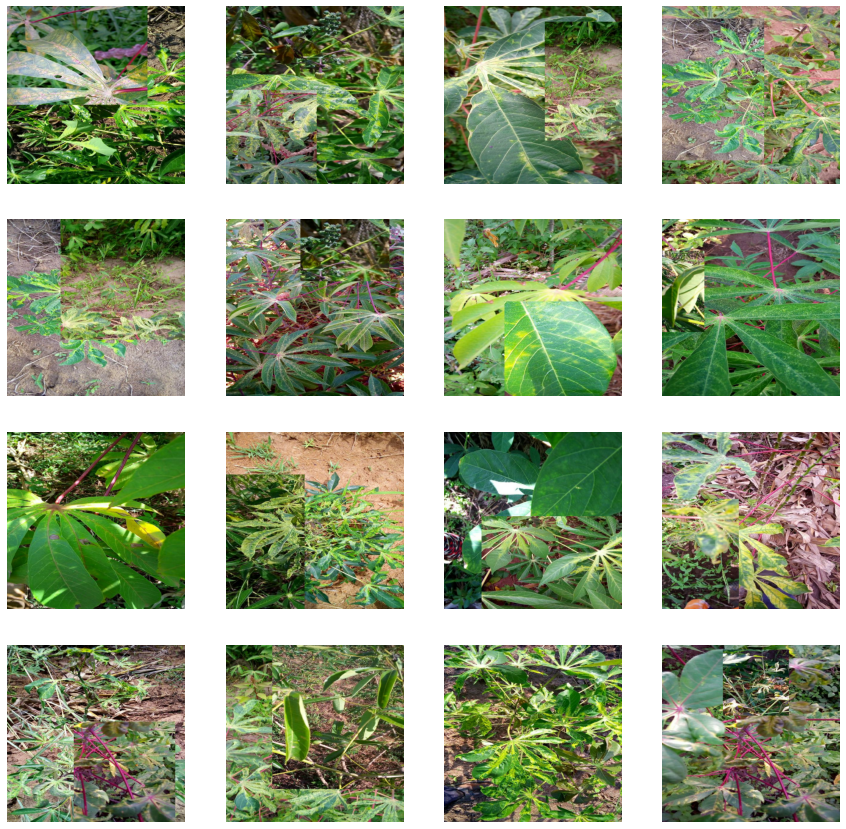

In [16]:
def apply_cutmix_on_example(img, label):
    img, label = CutMix(img, label, BaseConfig.IMAGE_SIZE[0], 1)
    return img, label

row = 4
col = 4
row = min(row, BaseConfig.BATCH_SIZE//col)

all_elements = get_training_dataset(load_dataset(BaseConfig.TRAINING_FILENAMES), augment=False).unbatch()
augmented_element = all_elements.repeat().batch(BaseConfig.BATCH_SIZE).map(apply_cutmix_on_example)

for (img, label) in augmented_element:
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

**MixUp Augmentation**

In [17]:
def MixUp(image, label, DIM, PROBABILITY=1.0):
#     # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
#     # output - a batch of images with mixup applied
#     CLASSES = len(BaseConfig.CLASSES)
    
#     imgs = []; labs = []
#     for j in range(len(image)):
#         # DO MIXUP WITH PROBABILITY DEFINED ABOVE
#         P = tf.cast( tf.random.uniform([], 0, 1) <= PROBABILITY, tf.int32)
                   
#         # CHOOSE RANDOM
#         k = tf.cast(tf.random.uniform([], 0, len(image)), tf.int32)
        
#         # this is beta dist with alpha=1.0
#         a = tf.random.uniform([], 0, 1) * P
                    
#         # MAKE MIXUP IMAGE
#         img1 = image[j,]
#         img2 = image[k,]
#         imgs.append((1-a)*img1 + a*img2)
                    
#         # MAKE CUTMIX LABEL
#         labs.append((1-a)*label[j] + a*label[k])
            
#     # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
#     image2 = tf.reshape(tf.stack(imgs), (len(image), DIM, DIM, 3))
#     label2 = tf.reshape(tf.stack(labs), (len(image), CLASSES))

    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = BaseConfig.IMAGE_SIZE[0]
    CLASSES = len(BaseConfig.CLASSES)
    AUG_BATCH = BaseConfig.BATCH_SIZE
        
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        labs.append((1-a)*label[j] + a*label[k])
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,))
    
    return image2, label2

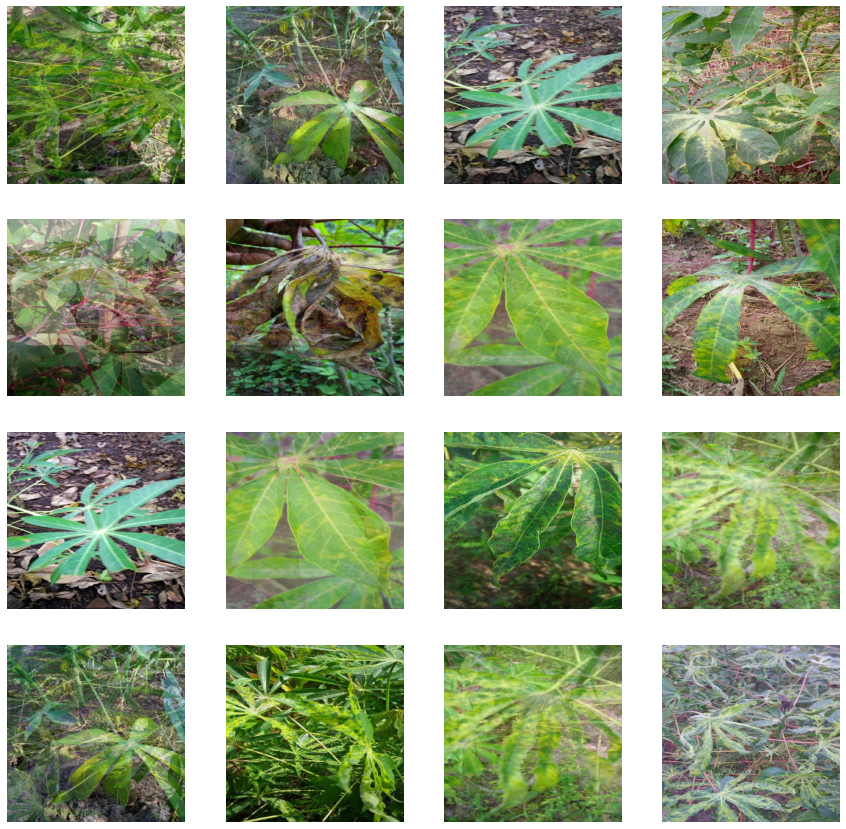

In [18]:
def apply_mixup_on_example(img, label):
    img, label = MixUp(img, label, BaseConfig.IMAGE_SIZE[0], 1)
    return img, label

row = 4
col = 4
row = min(row, BaseConfig.BATCH_SIZE//col)

all_elements = get_training_dataset(load_dataset(BaseConfig.TRAINING_FILENAMES), augment=False).unbatch()
augmented_element = all_elements.repeat().batch(BaseConfig.BATCH_SIZE).map(apply_mixup_on_example)

for (img, label) in augmented_element:
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

**FMix Augmentation**

In [19]:
sys.path.insert(0, '/kaggle/input/pyutils')
from fmix_utils import sample_mask

def FMix(image, label, DIM,  alpha=1, decay_power=3, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, (DIM, DIM), max_soft, reformulate)
    
    index = tf.constant(np.random.permutation(BaseConfig.BATCH_SIZE))
    # Using the below line gives error so using the BaseConfig.BATCH_SIZE,
    # image.shape[0] also represents batch size but since the tf.data.Dataset
    # used here have a used the .repeat() method without parameter on them 
    # which repeats the dataset infinitely
    # index = tf.constant(np.random.permutation(int(image.shape[0])))
    
    mask  = np.expand_dims(mask, -1)
    
    # samples 
    image1 = image * mask
    image2 = tf.gather(image, index) * (1 - mask)
    image3 = image1 + image2

    # labels
    label1 = label * lam 
    label2 = tf.gather(label, index) * (1 - lam)
    label3 = label1 + label2 
    
    return image3, label3

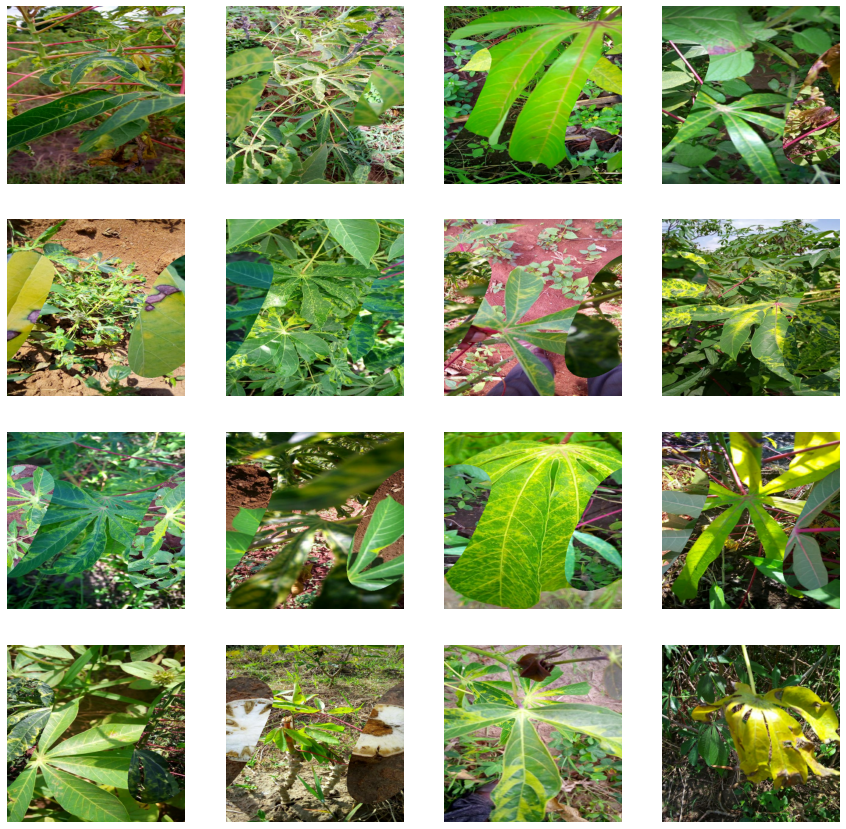

In [20]:
def apply_fmix_on_example(img, label):
    img, label = FMix(img, label, BaseConfig.IMAGE_SIZE[0])
    return img, label

row = 4
col = 4
row = min(row, BaseConfig.BATCH_SIZE//col)

all_elements = get_training_dataset(load_dataset(BaseConfig.TRAINING_FILENAMES), augment=False).unbatch()
augmented_element = all_elements.repeat().batch(BaseConfig.BATCH_SIZE).map(apply_fmix_on_example)

for (img, label) in augmented_element:
    plt.figure(figsize=(15, int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row, col, j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

In [21]:
# In this function all the `sophisticated` augmentations are applied
def transform(image, label):
    DIM = BaseConfig.IMAGE_SIZE[0]
    CLASSES = len(BaseConfig.CLASSES)
    
    SWITCH = 0.5
    CUTMIX_PROB = 0.2
    MIXUP_PROB = 0.1
    
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = CutMix(image, label, DIM, CUTMIX_PROB)
    image3, label3 = MixUp(image, label, DIM, MIXUP_PROB)
    
    # Not using FMix as it doesn't give good results, the loss become NaN and 
    # accuracy was very bad 
    # if np.random.rand() > 0.1:
    #     image4, label4 = FMix(image, label, DIM)
    
    imgs = []; labs = []
    for j in range(BaseConfig.BATCH_SIZE):
        P = tf.cast(tf.random.uniform([], 0, 1) <= SWITCH, tf.float32)
        
        # While using FMix uncomment 2 lines below and comment the other 2 lines
        # imgs.append(P*image2[j,] + (1-P)*image3[j,] + image4[j,])
        # labs.append(P*label2[j,] + (1-P)*label3[j,] + label4[j,])
        
        imgs.append(P*image2[j,] + (1-P)*image3[j,])
        labs.append(P*label2[j,] + (1-P)*label3[j,])
                
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image5 = tf.reshape(tf.stack(imgs), (BaseConfig.BATCH_SIZE, DIM, DIM, 3))
    label5 = tf.reshape(tf.stack(labs), (BaseConfig.BATCH_SIZE, 1))
    # label5 = tf.cast(label5, tf.int32)
    
    return image5, label5    

## 🏋️‍♀️ Modelling

![](https://media.giphy.com/media/3o7TKWC4IgROm4Qdc4/giphy.gif)

**Building the CustomCallback for getting more info on model's performance**


In [22]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss      = logs['loss']
        accuracy  = logs['accuracy']
        
        # Validation info
        val_loss      = logs['val_loss']
        val_accuracy  = logs['val_accuracy']
        
        info = {
            'loss': round(loss, 5),
            'accuracy': round(accuracy, 4),
            
            'val_loss': round(val_loss, 5),
            'val_accuracy': round(val_accuracy, 4),
        }
        
        print(f'\n{json.dumps(info, indent=2)}')
        print()

In [23]:
# Other callbacks

# Since the competition needs the best accuracy score
# therefore monitoring accuracy
model_checkpoints = ModelCheckpoint(
    'model.h5', save_best_only=True,
    monitor='val_accuracy', mode='max',
    verbose=1
    
)

early_stopping = EarlyStopping(
    monitor='val_loss', mode='min',
    patience=7, restore_best_weights=True,
    verbose=1
)

**Learning Rate Scheduler**

Learning rate schedule: 1e-08 to 0.00024 to 6.29e-08


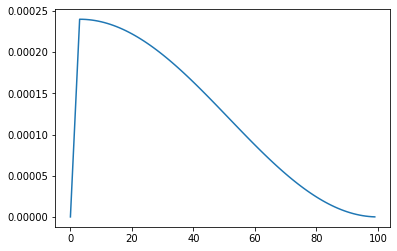

In [24]:
scheduler = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)


# ==============================
# Custom Learning Rate Schedule
# ==============================

# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

LR_START = 1e-8
LR_MIN = 1e-8
LR_MAX = 3e-5 * strategy.num_replicas_in_sync
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = .5

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (BaseConfig.EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
        lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
        if LR_MIN is not None:
            lr = tf.math.maximum(LR_MIN, lr)
            
    return lr
    
lr_scheduler = LearningRateScheduler(lrfn)


rng = [i for i in range(25 if BaseConfig.EPOCHS<25 else BaseConfig.EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [25]:
# All the callbacks
CALLBACKS = [
    model_checkpoints,
    # early_stopping,
    lr_scheduler,
    CustomCallback()
]

In [26]:
OPTIMIZER = Adam()
LOSS = 'sparse_categorical_crossentropy'

In [27]:
def build_model():
    with strategy.scope():
        inputs = Input(shape=[*BaseConfig.IMAGE_SIZE, 3])
        base_model = InceptionV3(weights='imagenet', include_top=False)
        base_model.trainable = True
        
        model_layers = [
            inputs,
            base_model,
            GlobalAveragePooling2D(),
            Dropout(0.25)
        ]
        
        if MIXED_PRECISION:
            # Since using mixed precision we have to use tf.float32 as dtype in our last layer
            # So that's why breaking them in to Dense (with no activation) and Activation layer
            model_layers.extend([
                Dense(len(BaseConfig.CLASSES)),
                Activation('softmax', dtype='float32')
            ])
        else:
            model_layers.extend([
                Dense(len(BaseConfig.CLASSES), activation='softmax')
            ])
        
        model = Sequential(model_layers)
        
        # Metrics
        METRICS = ['accuracy']

    model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)         
    return model

**Training without cross validaiton**

In [28]:
def train_without_cross_validation():
    # splitting the data for training and validation
    TRAINING_FILENAME, VAL_FILENAME = train_test_split(
        tf.io.gfile.glob(BaseConfig.GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
        test_size=0.2, random_state=0
    )
    
    # Creating pd.Dataframe 
    train_df = pd.DataFrame({ 'TRAINING_FILENAMES': TRAINING_FILENAME })['TRAINING_FILENAMES']
    val_df   = pd.DataFrame({ 'TRAINING_FILENAMES': VAL_FILENAME })['TRAINING_FILENAMES']
    
    # Loading datasets
    train_dataset = load_dataset(list(train_df), labeled=True)
    val_dataset   = load_dataset(list(val_df), labeled=True, ordered=True)
    
    # Getting nums of steps per epoch and validation step per epoch as 
    # we are used tf.data.Dataset.repeat() method on our dataset, so 
    # we need to tell our algorithm when to stop iterating through 
    # the dataset as repeat() without parameter will generate dataset 
    # of infinite length
    
    train_files = list(train_df)
    val_files   = list(val_df)
    num_train_imgs = count_data_items(train_files)
    num_val_imgs   = count_data_items(val_files)
    steps_per_epoch = num_train_imgs // BaseConfig.BATCH_SIZE
    validation_steps_per_epoch = num_val_imgs // BaseConfig.BATCH_SIZE
    
    # Data pre-processing + Augmentation
    train = get_training_dataset(train_dataset)
    val   = get_validation_dataset(val_dataset)

    # Getting the model
    model = build_model()
    
    # Training the model
    history = model.fit(
        train,
        steps_per_epoch=steps_per_epoch,
        epochs=BaseConfig.EPOCHS,
        callbacks=CALLBACKS,
        validation_data=val,
        validation_steps=validation_steps_per_epoch,
        verbose=1
    )
    
    return history, model

**Training with cross validation**

In [29]:
def train_with_cross_validation(folds=BaseConfig.FOLDS):
    models = []
    histories = []
    kFold = KFold(folds, shuffle=True, random_state=0)
    
    for fold, (train_idx, val_idx) in enumerate(kFold.split(BaseConfig.TRAINING_FILENAMES)):
        print()
        print('#'*25)
        print(f'### FOLD - {fold + 1} ###')
        print('#'*25)
        
        # Splitting the data for training and validation
        train_df = pd.DataFrame({ 'TRAINING_FILENAMES': BaseConfig.TRAINING_FILENAMES }).loc[train_idx]['TRAINING_FILENAMES']
        val_df   = pd.DataFrame({ 'TRAINING_FILENAMES': BaseConfig.TRAINING_FILENAMES }).loc[val_idx]['TRAINING_FILENAMES']
        
        # Loading datasets
        train_dataset = load_dataset(list(train_df), labeled=True)
        val_dataset   = load_dataset(list(val_df), labeled=True, ordered=True)
        
        # Getting nums of steps per epoch and validation steps
        train_files = list(train_df)
        val_files   = list(val_df)
        num_train_imgs = count_data_items(train_files)
        num_val_imgs   = count_data_items(val_files)
        steps_per_epoch = num_train_imgs // BaseConfig.BATCH_SIZE
        validation_steps_per_epoch = num_val_imgs // BaseConfig.BATCH_SIZE
        
        # Data pre-processing + Augmentation
        train = get_training_dataset(train_dataset)
        val   = get_validation_dataset(val_dataset)

        # Getting the model
        model = build_model()

        # Training the model
        history = model.fit(
            train,
            steps_per_epoch=steps_per_epoch,
            epochs=BaseConfig.EPOCHS,
            callbacks=CALLBACKS,
            validation_data=val,
            validation_steps=validation_steps_per_epoch,
            verbose=1
        )
        
        models.append(model)
        histories.append(history)
        
    return histories, models

**While training make predictions for each model in the respective fold**

In [30]:
def train_cv_and_predict(folds=BaseConfig.FOLDS):
    # Since we are splitting the dataset and iterating 
    # separately on imgs and ids, order matters
    test_ds = get_test_dataset(ordered=True)
    test_img_ds = test_ds.map(lambda img, idnum: img)
    
    print(f'Start training {folds} folds')
    histories, models = train_with_cross_validation(folds=folds)
    print('Computing predictions...')
    
    # Get the mean probability of the folds models
    probabilities = np.average(
        [models[i].predict(test_img_ds) for i in range(folds)],
        axis=0
    )
    
    predictions = np.argmax(probilities, axis=-1)
    
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda img, idnum: idnum).unbatch()
    
    # All in one batch
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    
    # Submitting the results
    np.savetxt(
        'submission.csv',
        np.rec.fromarrays([test_ids, predictions]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='image_id,label',
        comments=''
    )
    
    return histories, models

**Training and making prediction on model without cross validaiton**

In [31]:
def train_and_predict():
    # Since we are splitting the dataset and iterating
    # separately on imgs and ids, order matters
    test_ds = get_test_dataset(ordered=True)
    test_img_ds = test_ds.map(lambda img, idnum: img)
    
    print('Start training')
    history, model = train_without_cross_validation()
    print('Computing predictions...')
    
    # Get the mean probabiliy of the folds models
    probabilities = model.predict(test_img_ds)
    predictions   = np.argmax(probabilities, axis=-1)
    
    print('Generating submission.csv file...')
    test_ids_ds = test_ds.map(lambda img, idnum: idnum).unbatch()
    
    # All in one batch
    test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')
    
    # Submitting the results
    np.savetxt(
        'submission.csv',
        np.rec.fromarrays([test_ids, predictions]),
        fmt=['%s', '%d'],
        delimiter=',',
        header='image_id,label',
        comments=''
    )
    
    return history, model

In [32]:
history, model = train_without_cross_validation()

87916544/87910968 [==============================] - 2s 0us/step
Epoch 1/100
250/250 [==============================] - 123s 241ms/step - loss: 1.4592 - accuracy: 0.3976 - val_loss: 1.4428 - val_accuracy: 0.4810

Epoch 00001: val_accuracy improved from -inf to 0.48099, saving model to model.h5

{
  "loss": 1.45819,
  "accuracy": 0.4005,
  "val_loss": 1.44284,
  "val_accuracy": 0.481
}

Epoch 2/100
250/250 [==============================] - 41s 164ms/step - loss: 0.8758 - accuracy: 0.6605 - val_loss: 0.6116 - val_accuracy: 0.7897

Epoch 00002: val_accuracy improved from 0.48099 to 0.78972, saving model to model.h5

{
  "loss": 0.74068,
  "accuracy": 0.707,
  "val_loss": 0.61163,
  "val_accuracy": 0.7897
}

Epoch 3/100
250/250 [==============================] - 40s 161ms/step - loss: 0.6105 - accuracy: 0.7499 - val_loss: 0.5734 - val_accuracy: 0.7991

Epoch 00003: val_accuracy improved from 0.78972 to 0.79913, saving model to model.h5

{
  "loss": 0.59768,
  "accuracy": 0.7584,
  "val_lo

## 🧬 Evaluation

![](https://media.giphy.com/media/3orieSdZDhn7I6gViw/giphy.gif)

**Accuracy**

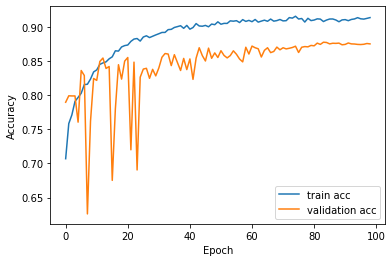

In [33]:
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'][1:], label='validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

**Loss**

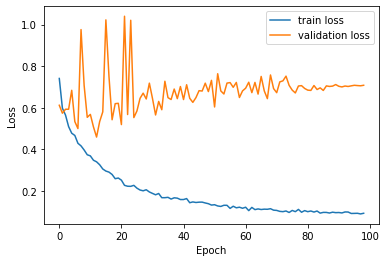

In [34]:
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'][1:], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [35]:
# confusion matrix
def display_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Inferring validation images

Since using `tfrecords` we have to extra step to create `confusion matrix`

In [36]:
# Labels, probabilities and predictions
all_labels = []
all_prob = []
all_pred = []

In [37]:
print('Inferring validation images...')

# Getting the validation set ready (predictions will be done on 
# and it will be used to plot the confusion matrix)
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(BaseConfig.GCS_PATH + '/train_tfrecords/ld_train*.tfrec'),
    test_size=0.2, random_state=0
)

# Getting filenames and dataset size
VAL_FILES = list(pd.DataFrame({'TRAINING_FILENAMES': VALID_FILENAMES})['TRAINING_FILENAMES'])
NUM_VALIDATION_IMAGES = count_data_items(VAL_FILES)
NUM_VALIDATION_IMAGES

Inferring validation images...


5352

In [38]:
# loading validation set
cmdataset = get_validation_dataset(load_dataset(VAL_FILES, labeled=True, ordered=True))

# validation imgs
images_ds = cmdataset.map(lambda image, label: image)

# validation labels (all in one batch)
labels_ds = cmdataset.map(lambda image, label: label).unbatch()
all_labels.append(next(iter(labels_ds.batch(NUM_VALIDATION_IMAGES))).numpy())

In [39]:
# Predicting
prob = model.predict(images_ds)

In [40]:
# Probabilities
all_prob.append(prob)

# Predicted labels
all_pred.append(np.argmax(prob, axis=-1))

In [41]:
cm_correct_labels = np.concatenate(all_labels)
cm_probabilities = np.concatenate(all_prob)
cm_predictions = np.concatenate(all_pred)

print(all_labels)
print(cm_correct_labels)

[array([3., 3., 3., ..., 2., 3., 3.], dtype=float32)]
[3. 3. 3. ... 2. 3. 3.]


In [42]:
print("Correct   labels: ", cm_correct_labels.shape, cm_correct_labels)
print("Predicted labels: ", cm_predictions.shape, cm_predictions)

Correct   labels:  (5352,) [3. 3. 3. ... 2. 3. 3.]
Predicted labels:  (5352,) [3 3 3 ... 2 3 3]


In [43]:
classes_num = len(BaseConfig.CLASSES)

cmat = confusion_matrix(cm_correct_labels, cm_predictions, labels=range(classes_num))
score = f1_score(cm_correct_labels, cm_predictions, labels=range(classes_num), average='weighted')
precision = precision_score(cm_correct_labels, cm_predictions, labels=range(classes_num), average='weighted')
recall = recall_score(cm_correct_labels, cm_predictions, labels=range(classes_num), average='weighted')

print('f1 score: {:.3f}, precision: {:.3f}, recall: {:.3f}'.format(score, precision, recall))

f1 score: 0.875, precision: 0.875, recall: 0.875


Normalized confusion matrix


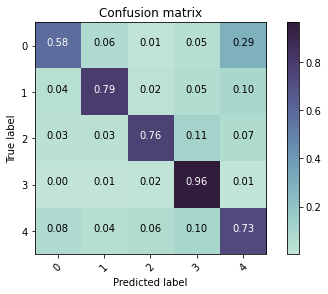

In [44]:
display_confusion_matrix(cmat, BaseConfig.CLASSES, True)

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/1ncv8cQdrpLjzn4wOz/giphy.gif)

---